In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from collections import Counter

from sklearn.metrics import classification_report, accuracy_score, f1_score


In [ ]:
s_data = pd.read_csv('healthcare-dataset-stroke-data.csv')

# **EDA**

In [99]:
print(s_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None


In [100]:
# Display value counts for categorical columns
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_cols:
    print(f"\nValue counts for {col}:\n")
    print(s_data[col].value_counts())


Value counts for gender:

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

Value counts for ever_married:

ever_married
Yes    3353
No     1757
Name: count, dtype: int64

Value counts for work_type:

work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

Value counts for Residence_type:

Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64

Value counts for smoking_status:

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64


In [101]:
print(s_data.head(3))

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   

   stroke  
0       1  
1       1  
2       1  


### Visualizing the data

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


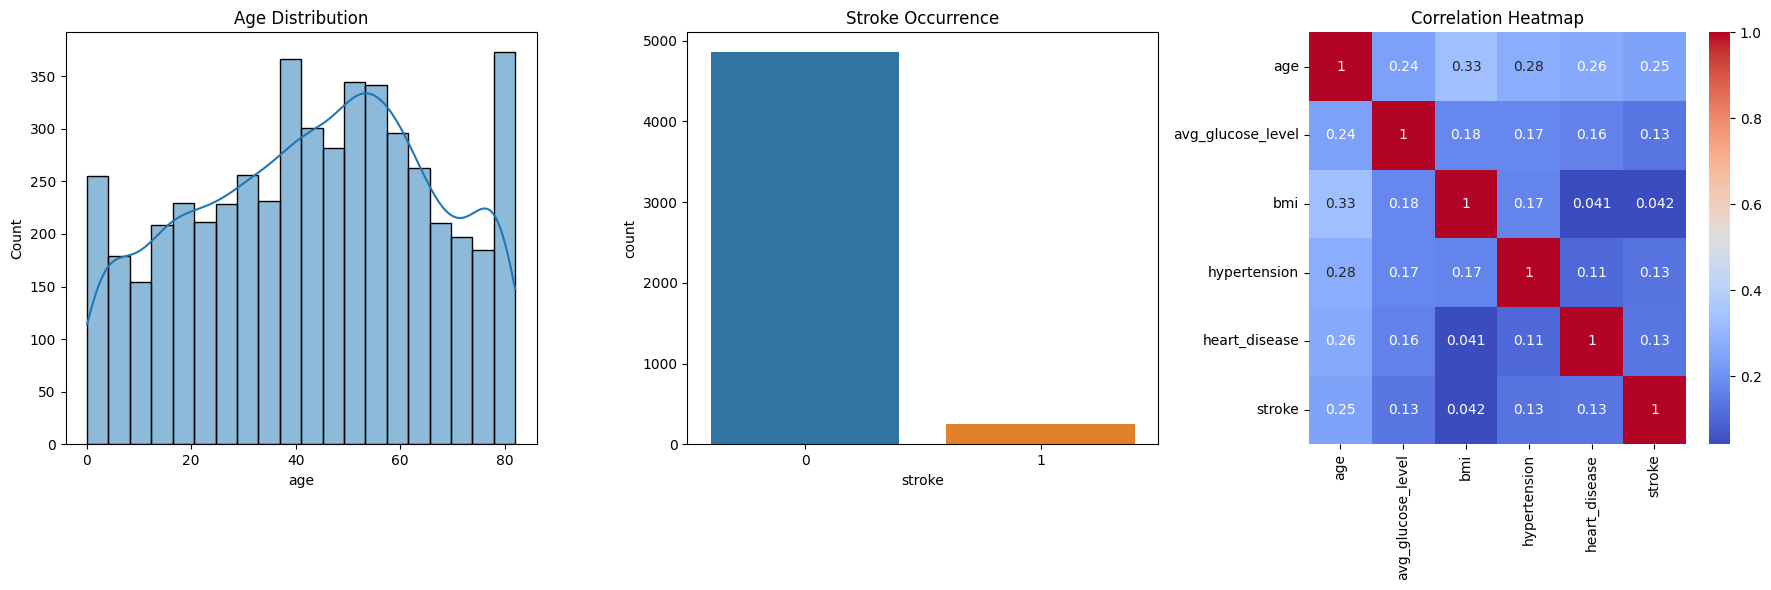

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  

sns.histplot(s_data['age'], bins=20, kde=True, ax=axes[0]) # age distribution
axes[0].set_title("Age Distribution")

sns.countplot(x='stroke', data=s_data, ax=axes[1])# stroke occurrence countplot
axes[1].set_title("Stroke Occurrence")

numerical_features = ['age', 'avg_glucose_level','bmi','hypertension','heart_disease','stroke']
sns.heatmap(s_data[numerical_features].corr(), annot=True, cmap='coolwarm', ax=axes[2]) # obviously a heatmap :)
axes[2].set_title("Correlation Heatmap")

plt.tight_layout()
plt.show()

**The Age Distribution chart** shows that the data is almost uniform but has peaks around ages 40 and 60.</br> **The Stroke Occurrence countplot** highlights a class imbalance, where the majority of cases do not involve strokes (stroke = 0).</br> **The Correlation Heatmap** shows that BMI, age, and hypertension have moderate positive correlations with the stroke target, suggesting potential importance for predictive modeling.

# **Data Preprocessing**

### Handling Missing Values
Missing values only exist in BMI column, we will impute missing BMI values based on the BMI of each person's respective age group for more accurate results.

In [ ]:
s_data = s_data.drop(['id','work_type', 'ever_married', 'Residence_type'], axis=1);
s_data['gender'] = s_data['gender'].str.strip().str.title(); s_data = s_data[s_data['gender'] != 'Other']

missing_values = s_data.isnull().sum()
print('Number of missing values in each column:\n', missing_values)

Number of missing values in each column:
 gender                 0
age                    0
hypertension           0
heart_disease          0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [ ]:
bins = [0, 5, 11, 16, 25, 35, 46, 57, 68, 100]
labels = ['<5', '6-11', '12-16', '17-25', '25-35',
          '36-46', '47-57', '58-68', '>68']
s_data['age_group'] = pd.cut(s_data['age'], bins=bins,
                             labels=labels, right=False)

age_group_means = s_data.groupby('age_group')['bmi'].mean()

# Function to impute missing BMI values based on the mean BMI of the age group
def impute_bmi(row):
    if np.isnan(row['bmi']):
        return age_group_means[row['age_group']]  # use the mean BMI of the respective age group
    else:
        return row['bmi']

s_data['bmi'] = s_data.apply(impute_bmi, axis=1)


print(s_data['bmi'].isnull().sum())  # do any missing BMI values remain? 

0


<ipython-input-104-76f0f651271f>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_means = s_data.groupby('age_group')['bmi'].mean()


## Feature Engineering

In [105]:
s_data['bmi_glucose_interaction'] = s_data['bmi'] * s_data['avg_glucose_level']

## Data Split

In [106]:
X = s_data.drop(columns=['age_group', 'bmi', 'avg_glucose_level', 'stroke']) # interaction term makes up for bmi & glucose
y = s_data['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

## One-hot Encoding

In [107]:
X_train = pd.get_dummies(X_train, columns=['smoking_status'], drop_first=False)
X_test = pd.get_dummies(X_test, columns = ['smoking_status'], drop_first=False)

smoking_columns = [col for col in X_train.columns if col.startswith('smoking_status')]
X_train[smoking_columns] = X_train[smoking_columns].astype(int)
X_test[smoking_columns] = X_test[smoking_columns].astype(int)

X_train['gender'] = X_train['gender'].map({'Male': 0, 'Female': 1})
X_test['gender'] = X_test['gender'].map({'Male': 0, 'Female': 1})
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4087 entries, 845 to 5053
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          4087 non-null   int64  
 1   age                             4087 non-null   float64
 2   hypertension                    4087 non-null   int64  
 3   heart_disease                   4087 non-null   int64  
 4   bmi_glucose_interaction         4087 non-null   float64
 5   smoking_status_Unknown          4087 non-null   int64  
 6   smoking_status_formerly smoked  4087 non-null   int64  
 7   smoking_status_never smoked     4087 non-null   int64  
 8   smoking_status_smokes           4087 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 319.3 KB
None


## Resampling

In [108]:
smote = SMOTE(sampling_strategy=0.6, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled.head(3)
print("Original data distribution:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())

Original data distribution: stroke
0    3888
1     199
Name: count, dtype: int64
After SMOTE: stroke
0    3888
1    2332
Name: count, dtype: int64


## Scaling

In [109]:
scaler = StandardScaler()

numerical_features = ['age', 'bmi_glucose_interaction', 'hypertension', 'heart_disease']

X_train_resampled[numerical_features] = scaler.fit_transform(X_train_resampled[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

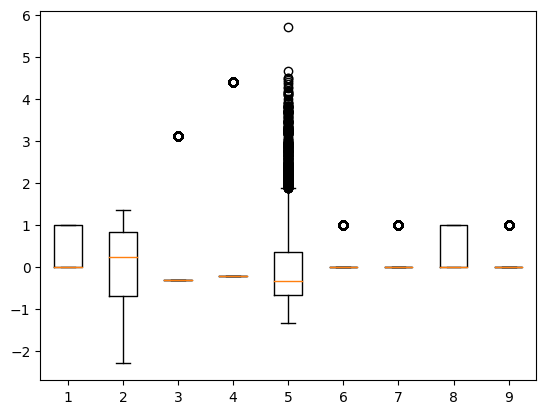

In [110]:
plt.boxplot(X_train_resampled)
plt.show()

In [111]:
feature_name = X_train_resampled.columns[4] 
feature_name

'bmi_glucose_interaction'

In [112]:
bmi_glucose_interaction = X_train_resampled['bmi_glucose_interaction']  

q1, q3 = np.percentile(bmi_glucose_interaction, [25, 75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = bmi_glucose_interaction[(bmi_glucose_interaction < lower_bound) | (bmi_glucose_interaction > upper_bound)]
print(f"Number of outliers in 'bmi_glucose_interaction': {len(outliers)}")

Number of outliers in 'bmi_glucose_interaction': 410


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


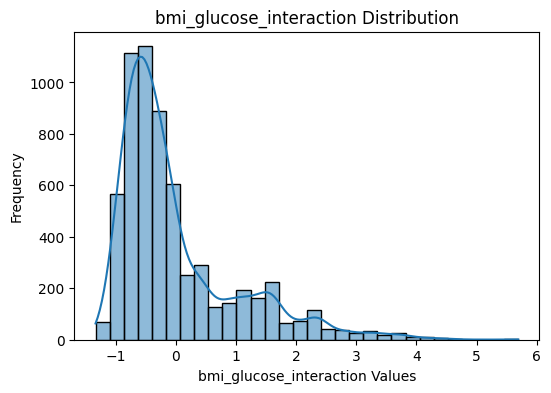

In [113]:
plt.figure(figsize=(6, 4))
sns.histplot(bmi_glucose_interaction, kde=True, bins=30)
plt.title("bmi_glucose_interaction Distribution")
plt.xlabel("bmi_glucose_interaction Values")
plt.ylabel("Frequency")
plt.show()

## Yeo Johnson Transformation

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


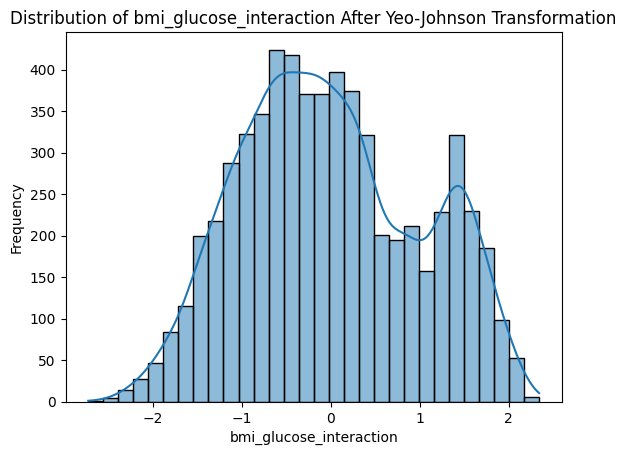

In [114]:
yeo_johnson = PowerTransformer(method='yeo-johnson', standardize=True)

X_train_resampled['bmi_glucose_interaction'] = yeo_johnson.fit_transform(X_train_resampled[['bmi_glucose_interaction']])

sns.histplot(X_train_resampled['bmi_glucose_interaction'], kde=True, bins=30)
plt.title(f"Distribution of bmi_glucose_interaction After Yeo-Johnson Transformation")
plt.xlabel('bmi_glucose_interaction')
plt.ylabel("Frequency")
plt.show()

# VIF

In [115]:
# VIF Calculation (to check multicollinearity)
vif_data = pd.DataFrame()
vif_data['Feature'] = X_train_resampled.columns
vif_data['VIF'] = [variance_inflation_factor(X_train_resampled.values, i) for i in range(X_train_resampled.shape[1])]
print("\nVIF Data:")
print(vif_data)


VIF Data:
                          Feature       VIF
0                          gender  1.960582
1                             age  1.344525
2                    hypertension  1.056986
3                   heart_disease  1.053801
4         bmi_glucose_interaction  1.178173
5          smoking_status_Unknown  1.460679
6  smoking_status_formerly smoked  1.155260
7     smoking_status_never smoked  1.436581
8           smoking_status_smokes  1.137697


Since none of the **VIF** values exceed 10, we conclude that there is no severe **multicollinearity** between the features. Therefore, we do not need to eliminate any feature at this stage.

# Grid Search

In [116]:
svm = SVC()

param_grid = {
    'C': [0.1, 20, 100], 
    'kernel': ['poly', 'rbf'], 
    'gamma': [1, 0.1, 0.01] 
}

In [117]:
"""grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_resampled, y_train_resampled)
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

best_params = grid_search.best_params_
"""

'grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring=\'f1\')\ngrid_search.fit(X_train_resampled, y_train_resampled)\nprint("Best Parameters:", grid_search.best_params_)\nprint("Best Cross-Validation Score:", grid_search.best_score_)\n\nbest_params = grid_search.best_params_\n'

The above cell was commented as it has taken 40 minutes to run

its results were as follows:

**Best Parameters: {'C': 20, 'gamma': 1, 'kernel': 'rbf'}**<br>
**Best Cross-Validation Score: 0.9104501607717042**

# SVM 

In [118]:
svm_final = SVC(kernel='rbf', 
                C=20, 
                gamma=1, 
                class_weight='balanced', 
                random_state=42)

svm_final.fit(X_train_resampled, y_train_resampled)

SVC(C=20, class_weight='balanced', gamma=1, random_state=42)

## SVM Evaluation and Confusion Matrix

In [119]:
y_pred = svm_final.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8806262230919765

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.91      0.94       972
           1       0.12      0.24      0.16        50

    accuracy                           0.88      1022
   macro avg       0.54      0.58      0.55      1022
weighted avg       0.92      0.88      0.90      1022



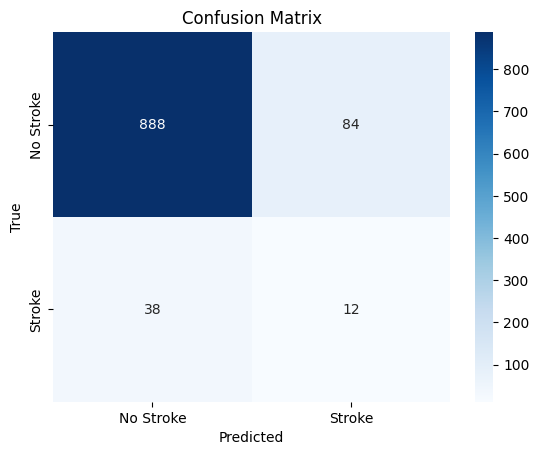

In [120]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## SVM Decision Boundaries

In [ ]:
pca = PCA(n_components=2) # reduce dataset components to 2
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test)

svm_final = SVC(kernel='rbf', 
                C=20, 
                gamma=1, 
                class_weight='balanced', 
                random_state=42)
svm_final.fit(X_train_pca, y_train_resampled)

# mesh grid (then predict on mesh grid using svm_final with rbf kernel)
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), 
                     np.arange(y_min, y_max, 0.01))

Z = svm_final.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

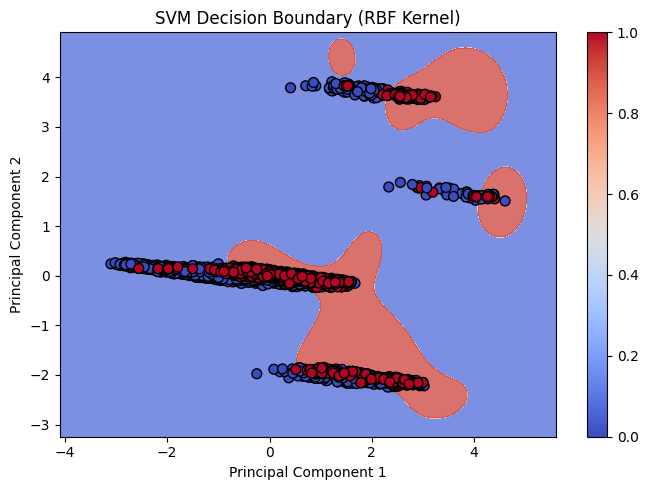

In [ ]:
plt.figure(figsize=(7, 5))
plt.contourf(xx, yy, Z, alpha=0.75, cmap='coolwarm')

plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_resampled, cmap='coolwarm', edgecolors='k', s=50)
plt.title('SVM Decision Boundary (RBF Kernel)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()

plt.tight_layout()
plt.show()

# MLP

In [123]:
model = Sequential([
    Dense(128, input_dim=X_train_resampled.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(64, activation='relu', kernel_regularizer=l2(0.02)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu', kernel_regularizer=l2(0.02)),
    BatchNormalization(),  
    Dropout(0.2),

    Dense(32, activation='relu', kernel_regularizer=l2(0.02)),
    BatchNormalization(),

    Dense(16, activation='relu'),
    BatchNormalization(),
    
    Dense(1, activation='sigmoid') 
])

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [124]:
history = model.fit(X_train_resampled, y_train_resampled, epochs=60, batch_size=64,
                    validation_data=(X_test, y_test))

Epoch 1/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5457 - loss: 3.9531 - val_accuracy: 0.0519 - val_loss: 3.9083
Epoch 2/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6227 - loss: 3.7278 - val_accuracy: 0.3200 - val_loss: 3.7501
Epoch 3/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6756 - loss: 3.5361 - val_accuracy: 0.5744 - val_loss: 3.5303
Epoch 4/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7224 - loss: 3.3701 - val_accuracy: 0.6781 - val_loss: 3.3135
Epoch 5/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7303 - loss: 3.2208 - val_accuracy: 0.7016 - val_loss: 3.1331
Epoch 6/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7510 - loss: 3.0630 - val_accuracy: 0.7290 - val_loss: 2.9607
Epoch 7/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7735 - loss: 2.9126 - val_accuracy: 0.7622 - val_loss: 2.7989
Epoch 8/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7802 - loss: 2.7830 - val_accuracy: 0.7828 - val_loss:

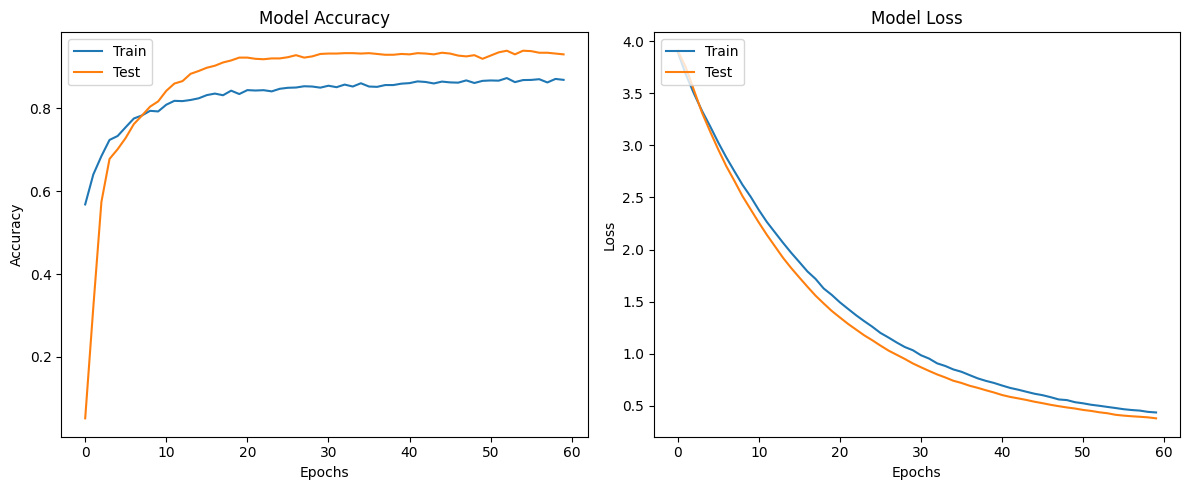

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)  
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)  
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout() 
plt.show()

In [ ]:
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype("int32") # convert probabilities to class labels (0 or 1)

f1_bn = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1_bn}")
print("Predictions on test set:", y_pred[3:12])

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
F1 Score: 0.924664497530326
Predictions on test set: [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [127]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       972
           1       0.20      0.14      0.16        50

    accuracy                           0.93      1022
   macro avg       0.58      0.56      0.56      1022
weighted avg       0.92      0.93      0.92      1022

Confusion Matrix:
[[944  28]
 [ 43   7]]


# RandomForest

In [128]:
rf_model = RandomForestClassifier(class_weight='balanced', n_estimators=70,
                                  max_depth=4,
                                  min_samples_split=5,
                                  random_state=42, bootstrap = True)
rf_model.fit(X_train_resampled, y_train_resampled)

y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:,1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test,y_prob))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.74      0.85       972
           1       0.14      0.82      0.24        50

    accuracy                           0.75      1022
   macro avg       0.56      0.78      0.55      1022
weighted avg       0.95      0.75      0.82      1022

Confusion Matrix:
 [[724 248]
 [  9  41]]
ROC-AUC Score: 0.7877263374485596
